# Plant Monitoring System - Two Models

## Model 1: Watering Prediction
**Data:** TARP.csv  
**Features:** Soil Moisture, Temperature, Humidity  
**Output:** Needs Watering (0/1)

## Model 2: Plant Health Classification
**Data:** plant_health_data.csv  
**Features:** Soil Moisture, Temperature, Humidity, Light Intensity, N, P, K  
**Output:** Health Status (Healthy / Moderate Stress / High Stress)

**Nutrient Standards:**
- Nitrogen: Deficient < 40 mg/kg, Optimal 40-120
- Phosphorus: Deficient < 10 mg/kg, Optimal 10-40
- Potassium: Deficient < 50 mg/kg, Optimal 50-200

## Import Libraries

In [7]:
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

print("✅ Libraries imported")

✅ Libraries imported


---
# MODEL 1: WATERING PREDICTION
---

### Load TARP.csv for Watering Model

In [8]:
# Load TARP dataset
df_tarp = pd.read_csv('../TARP.csv')
print(f"TARP Dataset: {df_tarp.shape}")
print(f"Columns: {df_tarp.columns.tolist()}")

# Prepare watering data (fixed schema)
required_map = {
    'SoilMoisture': 'Soil Moisture',
    'Temperature': 'Air temperature (C)',
    'Humidity': 'Air humidity (%)'
}

missing_required = [col for col in required_map.values() if col not in df_tarp.columns]
if missing_required:
    raise ValueError(f"Missing required columns in TARP.csv: {missing_required}")

watering_data = pd.DataFrame({k: df_tarp[v] for k, v in required_map.items()})

# Target: Pump Status (ON=1, OFF=0)
watering_data['NeedsWatering'] = (df_tarp['Status'] == 'ON').astype(int)

water_features = ['SoilMoisture', 'Temperature', 'Humidity']
watering_data[water_features] = watering_data[water_features].apply(pd.to_numeric, errors='coerce')

missing_before = watering_data[water_features + ['NeedsWatering']].isna().sum()

print(f"\n✅ Watering data prepared: {watering_data.shape}")
print(f"   Using features: {water_features}")
print(f"   Needs watering: {watering_data['NeedsWatering'].sum()} / {len(watering_data)}")
print("\nMissing values (will be imputed in training cell):")
print(missing_before)
print(f"\nSample data:")
print(watering_data.head())

TARP Dataset: (100000, 15)
Columns: ['Soil Moisture', 'Temperature', ' Soil Humidity', 'Time', 'Air temperature (C)', 'Wind speed (Km/h)', 'Air humidity (%)', 'Wind gust (Km/h)', 'Pressure (KPa)', 'ph', 'rainfall', 'N', 'P', 'K', 'Status']

✅ Watering data prepared: (100000, 4)
   Using features: ['SoilMoisture', 'Temperature', 'Humidity']
   Needs watering: 53650 / 100000

Missing values (will be imputed in training cell):
SoilMoisture         0
Temperature      76005
Humidity         76005
NeedsWatering        0
dtype: int64

Sample data:
   SoilMoisture  Temperature  Humidity  NeedsWatering
0            54        19.52     55.04              1
1            12        19.49     55.17              0
2            34        19.47     55.30              1
3             7        19.54     54.20              0
4            50        19.61     53.09              0


### Train Watering Model

In [9]:
# Prepare features and target
X_water = watering_data[water_features].astype(np.float32)
y_water = watering_data['NeedsWatering'].astype(np.float32)

# Split data
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_water, y_water, test_size=0.3, random_state=42, stratify=y_water
)

print(f"Training set: {len(X_train_w):,} samples")
print(f"Test set: {len(X_test_w):,} samples")

# Better imputation: fit only on training data to avoid leakage
water_imputer = KNNImputer(n_neighbors=5, weights='distance')
X_train_w_imp = water_imputer.fit_transform(X_train_w)
X_test_w_imp = water_imputer.transform(X_test_w)

print("Missing after train-fitted KNN imputation:")
print(f"  Train: {np.isnan(X_train_w_imp).sum()}")
print(f"  Test : {np.isnan(X_test_w_imp).sum()}")

# Build Keras watering model
water_norm = tf.keras.layers.Normalization(axis=-1, name='water_norm')
water_norm.adapt(X_train_w_imp)

watering_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(water_features),), name='watering_input'),
    water_norm,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid', name='watering_output')
])

watering_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_w = watering_model.fit(
    X_train_w_imp,
    y_train_w.values,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# Evaluate
water_probs = watering_model.predict(X_test_w_imp, verbose=0).flatten()
y_pred_w = (water_probs >= 0.5).astype(int)
accuracy_w = accuracy_score(y_test_w, y_pred_w)

print(f"\n{'='*60}")
print("WATERING MODEL RESULTS")
print(f"{'='*60}")
print(f"Accuracy: {accuracy_w:.4f}")
print(f"Last Val Accuracy: {history_w.history['val_accuracy'][-1]:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_w.astype(int), y_pred_w, target_names=['No Water', 'Needs Water']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test_w.astype(int), y_pred_w))

Training set: 70,000 samples
Test set: 30,000 samples
Missing after train-fitted KNN imputation:
  Train: 0
  Test : 0

WATERING MODEL RESULTS
Accuracy: 0.6618
Last Val Accuracy: 0.6666

Classification Report:
              precision    recall  f1-score   support

    No Water       0.68      0.51      0.58     13905
 Needs Water       0.65      0.80      0.72     16095

    accuracy                           0.66     30000
   macro avg       0.67      0.65      0.65     30000
weighted avg       0.67      0.66      0.65     30000


Confusion Matrix:
[[ 7032  6873]
 [ 3274 12821]]


---
# MODEL 2: PLANT HEALTH CLASSIFICATION
---

### Load plant_health_data.csv for Health Model

In [10]:
# Load plant health dataset
df_health = pd.read_csv('../plant_health_data.csv')
print(f"Plant Health Dataset: {df_health.shape}")
print(f"Columns: {df_health.columns.tolist()}")

# Prepare health data (fixed schema, no Plant_ID needed)
required_health_map = {
    'SoilMoisture': 'Soil_Moisture',
    'Temperature': 'Ambient_Temperature',
    'Humidity': 'Humidity',
    'LightIntensity': 'Light_Intensity',
    'Nitrogen': 'Nitrogen_Level',
    'Phosphorus': 'Phosphorus_Level',
    'Potassium': 'Potassium_Level',
    'HealthStatus': 'Plant_Health_Status'
}

missing_required = [col for col in required_health_map.values() if col not in df_health.columns]
if missing_required:
    raise ValueError(f"Missing required columns in plant_health_data.csv: {missing_required}")

health_data = pd.DataFrame({k: df_health[v] for k, v in required_health_map.items()})

health_features = ['SoilMoisture', 'Temperature', 'Humidity', 'LightIntensity', 'Nitrogen', 'Phosphorus', 'Potassium']
health_data[health_features] = health_data[health_features].apply(pd.to_numeric, errors='coerce')
health_data['HealthStatus'] = health_data['HealthStatus'].astype(str)

missing_before = health_data[health_features + ['HealthStatus']].isna().sum()

# Remove exact duplicates to reduce leakage/memorization
before_rows = len(health_data)
health_data = health_data.drop_duplicates(subset=health_features + ['HealthStatus']).reset_index(drop=True)
after_rows = len(health_data)

print(f"\n✅ Health data prepared: {health_data.shape}")
print(f"   Using features: {health_features}")
print(f"   Duplicates removed: {before_rows - after_rows}")
print("\nMissing values (features will be imputed in training cell):")
print(missing_before)
print(f"\nHealth Status Distribution:")
print(health_data['HealthStatus'].value_counts())
print(f"\nNutrient Statistics:")
print(health_data[['Nitrogen', 'Phosphorus', 'Potassium']].describe())

Plant Health Dataset: (1200, 14)
Columns: ['Timestamp', 'Plant_ID', 'Soil_Moisture', 'Ambient_Temperature', 'Soil_Temperature', 'Humidity', 'Light_Intensity', 'Soil_pH', 'Nitrogen_Level', 'Phosphorus_Level', 'Potassium_Level', 'Chlorophyll_Content', 'Electrochemical_Signal', 'Plant_Health_Status']

✅ Health data prepared: (1200, 8)
   Using features: ['SoilMoisture', 'Temperature', 'Humidity', 'LightIntensity', 'Nitrogen', 'Phosphorus', 'Potassium']
   Duplicates removed: 0

Missing values (features will be imputed in training cell):
SoilMoisture      0
Temperature       0
Humidity          0
LightIntensity    0
Nitrogen          0
Phosphorus        0
Potassium         0
HealthStatus      0
dtype: int64

Health Status Distribution:
HealthStatus
High Stress        500
Moderate Stress    401
Healthy            299
Name: count, dtype: int64

Nutrient Statistics:
          Nitrogen   Phosphorus    Potassium
count  1200.000000  1200.000000  1200.000000
mean     30.106751    30.264484    30.

### Train Health Model

In [11]:
# Prepare features and target
X_health = health_data[health_features].astype(np.float32)
y_health = health_data['HealthStatus'].astype(str)

# Encode class labels for neural network
health_label_encoder = LabelEncoder()
y_health_encoded = health_label_encoder.fit_transform(y_health)
health_classes = health_label_encoder.classes_.tolist()

# Split data
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_health, y_health_encoded, test_size=0.3, random_state=42, stratify=y_health_encoded
)

print(f"Training set: {len(X_train_h):,} samples")
print(f"Test set: {len(X_test_h):,} samples")

# Better imputation: fit only on training data to avoid leakage
health_imputer = KNNImputer(n_neighbors=5, weights='distance')
X_train_h_imp = health_imputer.fit_transform(X_train_h)
X_test_h_imp = health_imputer.transform(X_test_h)

print("Missing after train-fitted KNN imputation:")
print(f"  Train: {np.isnan(X_train_h_imp).sum()}")
print(f"  Test : {np.isnan(X_test_h_imp).sum()}")

# Build Keras health model
health_norm = tf.keras.layers.Normalization(axis=-1, name='health_norm')
health_norm.adapt(X_train_h_imp)

health_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(health_features),), name='health_input'),
    health_norm,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(health_classes), activation='softmax', name='health_output')
])

health_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_h = health_model.fit(
    X_train_h_imp,
    y_train_h,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# Evaluate
health_probs = health_model.predict(X_test_h_imp, verbose=0)
y_pred_h = np.argmax(health_probs, axis=1)
accuracy_h = accuracy_score(y_test_h, y_pred_h)

print(f"\n{'='*60}")
print("HEALTH MODEL RESULTS (Keras)")
print(f"{'='*60}")
print(f"Accuracy: {accuracy_h:.4f}")
print(f"Last Val Accuracy: {history_h.history['val_accuracy'][-1]:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_h, y_pred_h, target_names=health_classes))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test_h, y_pred_h))

Training set: 840 samples
Test set: 360 samples
Missing after train-fitted KNN imputation:
  Train: 0
  Test : 0

HEALTH MODEL RESULTS (Keras)
Accuracy: 0.9139
Last Val Accuracy: 0.8988

Classification Report:
                 precision    recall  f1-score   support

        Healthy       0.94      0.91      0.93        90
    High Stress       0.93      0.95      0.94       150
Moderate Stress       0.87      0.88      0.87       120

       accuracy                           0.91       360
      macro avg       0.91      0.91      0.91       360
   weighted avg       0.91      0.91      0.91       360


Confusion Matrix:
[[ 82   0   8]
 [  0 142   8]
 [  5  10 105]]


---
# SAVE MODELS
---

In [12]:
# Optional: save Keras models
watering_model.save('watering_model.keras')
health_model.save('health_model.keras')

# Helper for float32 TFLite export (no quantization)
def export_float32_tflite(model, output_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(output_path, 'wb') as f:
        f.write(tflite_model)
    return output_path

# Export float32 TFLite directly from trained notebook models
water_tflite_path = export_float32_tflite(watering_model, 'watering_model_float32.tflite')
health_tflite_path = export_float32_tflite(health_model, 'health_model_float32.tflite')

# Training stats (requested) from train split
water_train_array = X_train_w.values.astype(np.float32)
health_train_array = X_train_h.values.astype(np.float32)

water_means = np.mean(water_train_array, axis=0)
water_stds = np.std(water_train_array, axis=0)
health_means = np.mean(health_train_array, axis=0)
health_stds = np.std(health_train_array, axis=0)

print("\nWatering input stats")
print("Features:", water_features)
print("Means:", water_means)
print("Stds :", water_stds)

print("\nHealth input stats")
print("Features:", health_features)
print("Means:", health_means)
print("Stds :", health_stds)

# Metadata for ESP32/runtime integration
notebook_tflite_metadata = {
    'watering': {
        'features': water_features,
        'keras_model': 'watering_model.keras',
        'tflite_model': water_tflite_path,
        'tflite_dtype': 'float32',
        'task': 'binary_classification',
        'threshold': 0.5,
        'input_mean': water_means.tolist(),
        'input_std': water_stds.tolist(),
        'classes': ['No Water', 'Needs Water']
    },
    'health': {
        'features': health_features,
        'keras_model': 'health_model.keras',
        'tflite_model': health_tflite_path,
        'tflite_dtype': 'float32',
        'task': 'multiclass_classification',
        'input_mean': health_means.tolist(),
        'input_std': health_stds.tolist(),
        'classes': health_classes
    }
}

with open('notebook_tflite_metadata.json', 'w') as f:
    json.dump(notebook_tflite_metadata, f, indent=2)

print("\n" + "="*60)
print("✅ KERAS + FLOAT32 TFLITE EXPORT COMPLETED")
print("="*60)
print("\n📦 MODEL 1 (Watering)")
print("   Keras : watering_model.keras")
print("   TFLite: watering_model_float32.tflite")
print(f"   Input : {water_features}")
print("   Output: 0 = No water, 1 = Needs water")
print(f"   Accuracy: {accuracy_w:.2%}")

print("\n📦 MODEL 2 (Health)")
print("   Keras : health_model.keras")
print("   TFLite: health_model_float32.tflite")
print(f"   Input : {health_features}")
print(f"   Output classes: {health_classes}")
print(f"   Accuracy: {accuracy_h:.2%}")

print("\n📦 notebook_tflite_metadata.json")
print("   Contains feature schema, stats, class labels, and file names")
print("="*60)

INFO:tensorflow:Assets written to: /var/folders/qt/l3xnyqp57bq88kk29v8h87_40000gn/T/tmpr8f42k88/assets


INFO:tensorflow:Assets written to: /var/folders/qt/l3xnyqp57bq88kk29v8h87_40000gn/T/tmpr8f42k88/assets


Saved artifact at '/var/folders/qt/l3xnyqp57bq88kk29v8h87_40000gn/T/tmpr8f42k88'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='watering_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  4892225616: TensorSpec(shape=(1, 3), dtype=tf.float32, name=None)
  4892225040: TensorSpec(shape=(1, 3), dtype=tf.float32, name=None)
  4892226000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4892226960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4892226576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4892227536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4892227152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4892228112: TensorSpec(shape=(), dtype=tf.resource, name=None)
INFO:tensorflow:Assets written to: /var/folders/qt/l3xnyqp57bq88kk29v8h87_40000gn/T/tmpbxpll4nh/assets


W0000 00:00:1772093914.467429 2092155 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1772093914.467446 2092155 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2026-02-26 13:48:34.469172: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/qt/l3xnyqp57bq88kk29v8h87_40000gn/T/tmpr8f42k88
2026-02-26 13:48:34.469517: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2026-02-26 13:48:34.469522: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/qt/l3xnyqp57bq88kk29v8h87_40000gn/T/tmpr8f42k88
I0000 00:00:1772093914.473445 2092155 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2026-02-26 13:48:34.474754: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2026-02-26 13:48:34.489710: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

Saved artifact at '/var/folders/qt/l3xnyqp57bq88kk29v8h87_40000gn/T/tmpbxpll4nh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='health_input')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  4900520784: TensorSpec(shape=(1, 7), dtype=tf.float32, name=None)
  4900532880: TensorSpec(shape=(1, 7), dtype=tf.float32, name=None)
  4900522320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4900522128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4900521744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4900531152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4900531344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4900530576: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1772093914.860574 2092155 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.



Watering input stats
Features: ['SoilMoisture', 'Temperature', 'Humidity']
Means: [45.457584       nan       nan]
Stds : [25.998682       nan       nan]

Health input stats
Features: ['SoilMoisture', 'Temperature', 'Humidity', 'LightIntensity', 'Nitrogen', 'Phosphorus', 'Potassium']
Means: [ 25.02427   23.965229  54.883827 613.50757   30.426386  30.10565
  30.288227]
Stds : [  8.783868    3.3716474   8.696131  229.9505     11.453364   11.321841
  11.659513 ]

✅ KERAS + FLOAT32 TFLITE EXPORT COMPLETED

📦 MODEL 1 (Watering)
   Keras : watering_model.keras
   TFLite: watering_model_float32.tflite
   Input : ['SoilMoisture', 'Temperature', 'Humidity']
   Output: 0 = No water, 1 = Needs water
   Accuracy: 66.18%

📦 MODEL 2 (Health)
   Keras : health_model.keras
   TFLite: health_model_float32.tflite
   Input : ['SoilMoisture', 'Temperature', 'Humidity', 'LightIntensity', 'Nitrogen', 'Phosphorus', 'Potassium']
   Output classes: ['Healthy', 'High Stress', 'Moderate Stress']
   Accuracy: 91.

W0000 00:00:1772093914.860597 2092155 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2026-02-26 13:48:34.860877: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/qt/l3xnyqp57bq88kk29v8h87_40000gn/T/tmpbxpll4nh
2026-02-26 13:48:34.861260: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2026-02-26 13:48:34.861268: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/qt/l3xnyqp57bq88kk29v8h87_40000gn/T/tmpbxpll4nh
2026-02-26 13:48:34.864525: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2026-02-26 13:48:34.889999: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/qt/l3xnyqp57bq88kk29v8h87_40000gn/T/tmpbxpll4nh
2026-02-26 13:48:34.894835: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 33961 microseconds.


---
# NUTRIENT DEFICIENCY CHECK (Simple Rules)
---

In [13]:
def check_nutrients(nitrogen, phosphorus, potassium):
    """
    Check nutrient levels against agronomic standards.
    Does NOT require ML model - just simple if/else logic.
    
    Standards:
    - Nitrogen: Deficient < 40, Optimal 40-120
    - Phosphorus: Deficient < 10, Optimal 10-40
    - Potassium: Deficient < 50, Optimal 50-200
    """
    issues = []
    
    # Nitrogen check
    if nitrogen < 40:
        issues.append(f"⚠️ Low Nitrogen ({nitrogen:.1f} mg/kg) - Below 40")
    elif nitrogen > 120:
        issues.append(f"⚠️ High Nitrogen ({nitrogen:.1f} mg/kg) - Above 120")
    else:
        issues.append(f"✅ Nitrogen OK ({nitrogen:.1f} mg/kg)")
    
    # Phosphorus check
    if phosphorus < 10:
        issues.append(f"⚠️ Low Phosphorus ({phosphorus:.1f} mg/kg) - Below 10")
    elif phosphorus > 40:
        issues.append(f"⚠️ High Phosphorus ({phosphorus:.1f} mg/kg) - Above 40")
    else:
        issues.append(f"✅ Phosphorus OK ({phosphorus:.1f} mg/kg)")
    
    # Potassium check
    if potassium < 50:
        issues.append(f"⚠️ Low Potassium ({potassium:.1f} mg/kg) - Below 50")
    elif potassium > 200:
        issues.append(f"⚠️ High Potassium ({potassium:.1f} mg/kg) - Above 200")
    else:
        issues.append(f"✅ Potassium OK ({potassium:.1f} mg/kg)")
    
    return issues

# Example usage
print("="*60)
print("NUTRIENT CHECK FUNCTION (No ML needed)")
print("="*60)
print("\nExample 1: Deficient nutrients")
results = check_nutrients(nitrogen=35, phosphorus=8, potassium=45)
for r in results:
    print(r)

print("\nExample 2: Optimal nutrients")
results = check_nutrients(nitrogen=80, phosphorus=25, potassium=120)
for r in results:
    print(r)
print("="*60)

NUTRIENT CHECK FUNCTION (No ML needed)

Example 1: Deficient nutrients
⚠️ Low Nitrogen (35.0 mg/kg) - Below 40
⚠️ Low Phosphorus (8.0 mg/kg) - Below 10
⚠️ Low Potassium (45.0 mg/kg) - Below 50

Example 2: Optimal nutrients
✅ Nitrogen OK (80.0 mg/kg)
✅ Phosphorus OK (25.0 mg/kg)
✅ Potassium OK (120.0 mg/kg)


---
# COMPLETE EXAMPLE: Using Both Models + Nutrient Check
---

In [14]:
# Example sensor readings from ESP32
sensor_readings = {
    'SoilMoisture': 35.0,
    'Temperature': 25.0,
    'Humidity': 60.0,
    'LightIntensity': 700.0,
    'Nitrogen': 38.0,
    'Phosphorus': 25.0,
    'Potassium': 45.0
}

print("\n" + "="*60)
print("COMPLETE PLANT MONITORING EXAMPLE")
print("="*60)
print("\n📊 Sensor Readings:")
for key, value in sensor_readings.items():
    print(f"   {key}: {value}")

# Watering prediction (Keras)
water_input_df = pd.DataFrame([{feature: sensor_readings[feature] for feature in water_features}])
water_input_np = water_input_df.values.astype(np.float32)
water_prob = float(watering_model.predict(water_input_np, verbose=0)[0, 0])
needs_water = int(water_prob >= 0.5)
print(f"\n💧 WATERING: {'NEEDS WATER ❌' if needs_water else 'No water needed ✅'} (prob={water_prob:.3f})")

# Health prediction (Keras)
health_input_df = pd.DataFrame([{feature: sensor_readings[feature] for feature in health_features}])
health_input_np = health_input_df.values.astype(np.float32)
health_probs = health_model.predict(health_input_np, verbose=0)[0]
health_idx = int(np.argmax(health_probs))
health_status = health_classes[health_idx]
health_icon = "✅" if health_status == "Healthy" else "⚠️" if health_status == "Moderate Stress" else "❌"
print(f"🌱 HEALTH: {health_status} {health_icon} (confidence={health_probs[health_idx]:.3f})")

print(f"\n🧪 NUTRIENTS:")
nutrient_results = check_nutrients(
    sensor_readings['Nitrogen'],
    sensor_readings['Phosphorus'],
    sensor_readings['Potassium']
)
for result in nutrient_results:
    print(f"   {result}")

print("="*60)


COMPLETE PLANT MONITORING EXAMPLE

📊 Sensor Readings:
   SoilMoisture: 35.0
   Temperature: 25.0
   Humidity: 60.0
   LightIntensity: 700.0
   Nitrogen: 38.0
   Phosphorus: 25.0
   Potassium: 45.0

💧 WATERING: NEEDS WATER ❌ (prob=0.620)
🌱 HEALTH: Healthy ✅ (confidence=1.000)

🧪 NUTRIENTS:
   ⚠️ Low Nitrogen (38.0 mg/kg) - Below 40
   ✅ Phosphorus OK (25.0 mg/kg)
   ⚠️ Low Potassium (45.0 mg/kg) - Below 50


---
# SLIDE-READY EVALUATION (Accuracy, Loss Curves, Confusion Matrices)
---

SLIDE-READY METRICS
Watering Accuracy: 0.6618
Watering Last Val Accuracy: 0.6666
Health Accuracy: 0.9139
Health Last Val Accuracy: 0.8988


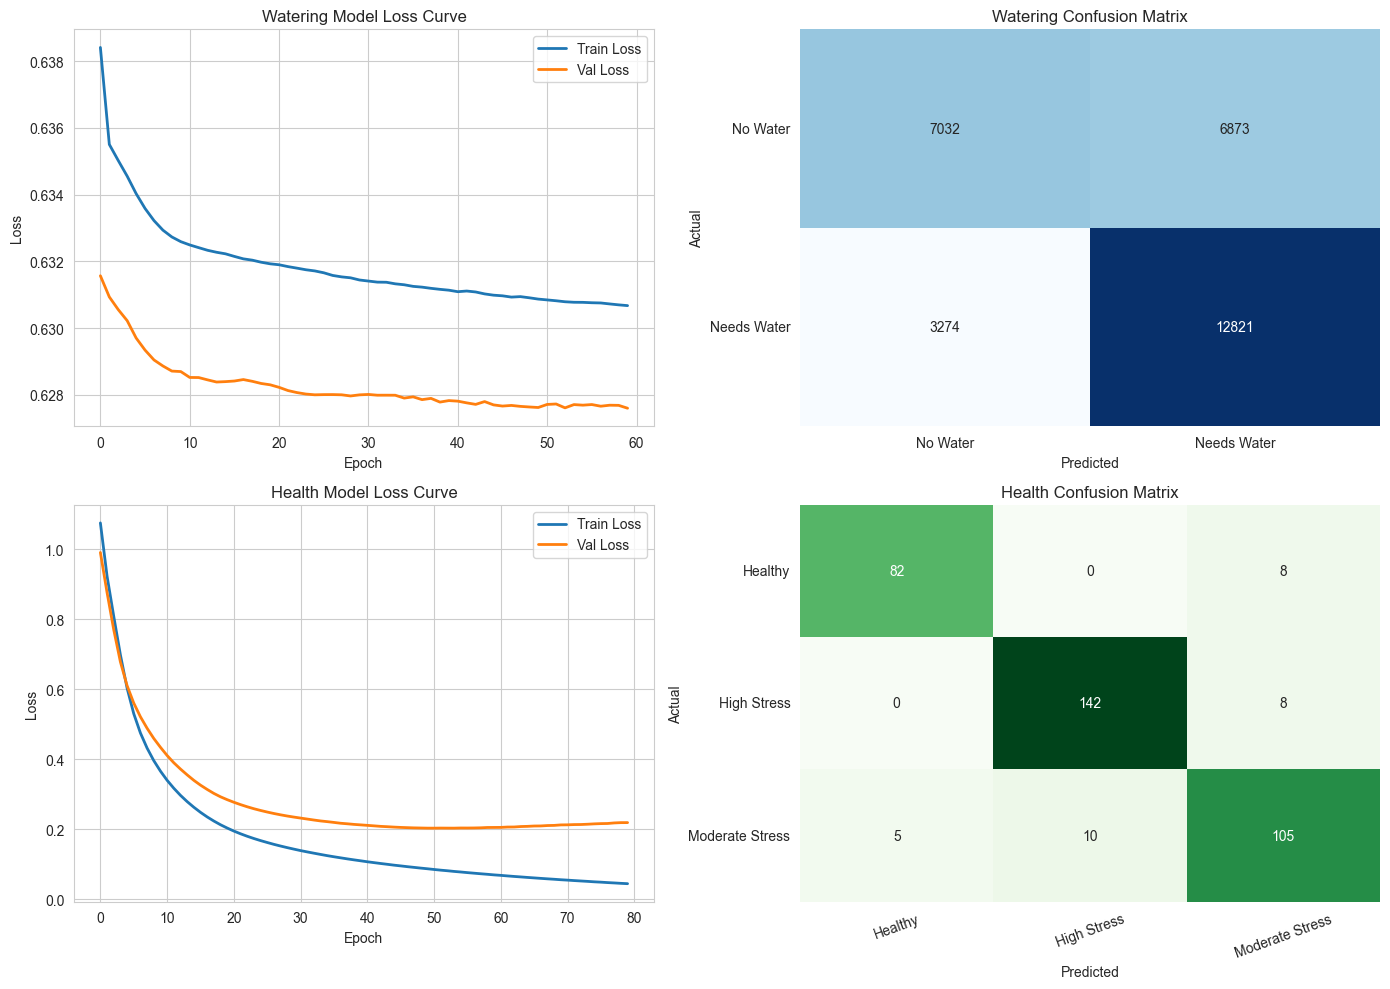

Tip: Take one screenshot of this output + plot grid for your PPT slide.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set_style('whitegrid')

print('='*70)
print('SLIDE-READY METRICS')
print('='*70)
print(f'Watering Accuracy: {accuracy_w:.4f}')
print(f'Watering Last Val Accuracy: {history_w.history["val_accuracy"][-1]:.4f}')
print(f'Health Accuracy: {accuracy_h:.4f}')
print(f'Health Last Val Accuracy: {history_h.history["val_accuracy"][-1]:.4f}')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Watering loss curve
axes[0, 0].plot(history_w.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history_w.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Watering Model Loss Curve')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Watering confusion matrix
cm_w = confusion_matrix(y_test_w.astype(int), y_pred_w)
sns.heatmap(cm_w, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 1])
axes[0, 1].set_title('Watering Confusion Matrix')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_xticklabels(['No Water', 'Needs Water'])
axes[0, 1].set_yticklabels(['No Water', 'Needs Water'], rotation=0)

# Health loss curve
axes[1, 0].plot(history_h.history['loss'], label='Train Loss', linewidth=2)
axes[1, 0].plot(history_h.history['val_loss'], label='Val Loss', linewidth=2)
axes[1, 0].set_title('Health Model Loss Curve')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Health confusion matrix
cm_h = confusion_matrix(y_test_h, y_pred_h)
sns.heatmap(cm_h, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1, 1])
axes[1, 1].set_title('Health Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_xticklabels(health_classes, rotation=20)
axes[1, 1].set_yticklabels(health_classes, rotation=0)

plt.tight_layout()
plt.show()

print('='*70)
print('Tip: Take one screenshot of this output + plot grid for your PPT slide.')
print('='*70)